In [ ]:
# v0 tries DQN

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from IPython.display import clear_output
from IPython import display
import minerl
import pickle

import numpy as np
from collections import deque
import double_dqn_agent
import importlib
importlib.reload(double_dqn_agent)

%matplotlib inline

In [2]:
environment_name = 'MineRLNavigateDense-v0'
%time env = gym.make(environment_name)

CPU times: user 188 ms, sys: 316 ms, total: 504 ms
Wall time: 1min 35s


In [3]:
SEED = 924
NORM_FACTOR = 255

def seed_everything(seed=SEED): 
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
ACTIONS = ['attack', 
           'back', 
           'camera_left', 
           'camera_right',
           'forward', 
           'jump', 
           'left',
           'place',
           'right', 
           'sneak',
           'sprint']
actions_dim = 2**len(ACTIONS) # we interpret camera yaw as discrete
print(actions_dim)
print(env.action_space)

2048
Dict(attack:Discrete(2), back:Discrete(2), camera:Box(2,), forward:Discrete(2), jump:Discrete(2), left:Discrete(2), place:Enum(none,dirt), right:Discrete(2), sneak:Discrete(2), sprint:Discrete(2))


In [5]:
state_dim = 1+64*64*3 # we ignore inventory
non_visual_state_dim = 1
print(env.observation_space)

Dict(compassAngle:Box(), inventory:Dict(dirt:Box()), pov:Box(64, 64, 3))


In [6]:
# def flatten_state(state):
#     flatten_state = state['pov'].reshape(-1)
#     return np.append(flatten_state, state['compassAngle']) / NORM_FACTOR

In [7]:
# net_reward = 0
# for i in range(100):
#     action = env.action_space.noop()

#     action['camera'] = [0, 0.03*obs["compassAngle"]]
#     action['back'] = 0
#     action['forward'] = 1
#     action['jump'] = 1
#     action['attack'] = 1

#     obs, reward, done, info = env.step(
#         action)  
    
#     if i%10==0:
#         plt.imshow(env.render(mode='rgb_array')) 
#         display.display(plt.gcf())
#         clear_output(wait=True)
#     net_reward += reward
# print("Total reward: ", net_reward) 

In [8]:
def convert_action(action_dec):
    bin_action = np.binary_repr(action_dec, width=len(ACTIONS))
    action = {}
    for n, act in enumerate(ACTIONS):
        action[act] = int(bin_action[n])
    if action['camera_left']==action['camera_right']:
        action['camera'] = [ 0, 0]
    else:
        if action['camera_left']==1:
            action['camera'] = [ 0, -20]
        if action['camera_right']==1:
            action['camera'] = [ 0, 20]
    del action['camera_left']
    del action['camera_right']
    return action

In [9]:
# Restart the agent
agent = double_dqn_agent.Agent(non_visual_state_dim, actions_dim, SEED)
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores

In [ ]:
n_episodes=2000 # maximum number of training episodes
max_t=1000 # maximum number of timesteps per episode
eps_start=1.0 #  starting value of epsilon, for epsilon-greedy action selection
eps_end=0.01 # minimum value of epsilon
eps_decay=0.995 # multiplicative factor (per episode) for decreasing epsilon


eps = eps_start                    # initialize epsilon

for i_episode in range(1, n_episodes+1):
    print(i_episode)
    state, _ = env.reset()
    score = 0
    for t in range(max_t):
        action_dec = agent.act([state['pov'].astype(float)], state['compassAngle'], eps)
        action = convert_action(action_dec)   
        next_state, reward, done, info = env.step(action)     
        agent.step(state, action_dec, reward, next_state, done)
        state = next_state
        score += reward     
        if done:
            break
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    print('\rEpisode {}\tMean Score: {:.2f}\tMax score: {:.2f}'.format(i_episode,
                                                                      np.mean(scores_window),
                                                                      np.max(scores_window)))
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f} \tLoss: {:.2f}'.format(i_episode, 
                                                                   np.mean(scores_window),
                                                                   agent.loss))
    if np.mean(scores_window)>=200.0:
        print('\nEnvironment solved in {:d} episodes!\tMean score: {:.2f}\tMax score: {:.2f}'.format(i_episode-100, np.mean(scores_window), np.max(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        break
    
    pickle.dump(scores,open('scores.pickle','wb'))




1
> /app/code/minerl/double_dqn_agent.py(93)learn()
-> actions_local = torch.gather(self.qnetwork_local(states['visual'], states['not_visual']), 1, actions)
(Pdb) actions
tensor([[ 392],
        [1637],
        [  64],
        [1209],
        [ 862],
        [ 409],
        [ 226],
        [ 332],
        [1721],
        [1734],
        [ 308],
        [1626],
        [1450],
        [ 391],
        [1815],
        [ 633],
        [ 178],
        [ 259],
        [1998],
        [ 674],
        [ 213],
        [1441],
        [1670],
        [ 810],
        [1111],
        [ 557],
        [2022],
        [ 379],
        [ 186],
        [ 940],
        [ 149],
        [ 773],
        [  43],
        [1033],
        [ 756],
        [1494],
        [ 228],
        [ 243],
        [1635],
        [  69],
        [1720],
        [ 502],
        [1983],
        [  84],
        [2043],
        [ 992],
        [ 947],
        [ 312],
        [1626],
        [ 531],
        [1272],
        [1942

(Pdb) gamma * torch.gather( self.qnetwork_target(next_states['visual'], next_states['not_visual']),                                                         1,                                                         best_action_local.unsqueeze(1)) * ((dones==0).float())
tensor([[-2.4991],
        [-1.6893],
        [-0.7402],
        [-3.1279],
        [-1.3121],
        [-2.0493],
        [-2.1067],
        [-1.4801],
        [-2.5689],
        [-1.6172],
        [ 0.3755],
        [ 0.2277],
        [ 1.4177],
        [-1.4711],
        [ 0.3168],
        [ 0.2779],
        [-3.1324],
        [-1.8122],
        [-2.7802],
        [-0.1608],
        [ 2.6685],
        [-3.1233],
        [-2.0308],
        [-1.5590],
        [-1.0516],
        [-2.2464],
        [ 0.5482],
        [-1.8281],
        [-2.4553],
        [ 1.6156],
        [-1.4616],
        [-2.0947],
        [-1.3686],
        [-2.7664],
        [-1.7554],
        [-1.5675],
        [-2.3280],
        [-3.0379],
        

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# DDPG (not implemented yet)

In [0]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", 
                                                                "action", 
                                                                "reward", 
                                                                "next_state", 
                                                                "done",
                                                                "td_error"])
        self.td_errors = []
    
    def add(self, states, actions, rewards, next_states, dones, td_errors):
        """Add a new experience to memory."""
        e = self.experience(states, actions, rewards, next_states, dones, td_errors)
        self.memory.append(e)
        self.td_errors.append(max(td_errors))
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        td_error_probs = self.get_td_errors_probs(self.td_errors)
        elements = np.random.choice(range(len(self.memory)), size=BATCH_SIZE, 
                                    p=td_error_probs, replace=False)
        experiences = [self.memory[element] for element in elements]
        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.stack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.stack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.stack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        td_errors = torch.from_numpy(np.stack([e.td_error for e in experiences if e is not None])).float().to(device)
  
        return (states, actions, rewards, next_states, dones, td_errors)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
        
    def get_td_errors_probs(self, td_errors):
        td_error_probs_scaled = np.abs(td_errors)**PE_ALPHA
        return td_error_probs_scaled / (np.abs(self.td_errors)**PE_ALPHA).sum()

In [12]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.2, sigma=1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.state = copy.copy(self.mu)
        self.size = size
        self.reset()

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.stat
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state
    
    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

In [13]:
def soft_update(local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [14]:
def layer_init(layer, w_scale=1):
    nn.init.uniform_(layer.weight.data, a=-LAYER_INIT_RANGE, b=LAYER_INIT_RANGE)
    layer.weight.data.mul_(w_scale)
    nn.init.uniform_(layer.bias.data, a=-LAYER_INIT_RANGE, b=LAYER_INIT_RANGE)
    return layer

In [15]:
class QFunction(nn.Module):
    def __init__(self, state_dim, actions_dim, hidden_units=(256, 128), 
                 activation=F.leaky_relu):
        super(QFunction, self).__init__()
        dims = (state_dim + actions_dim, ) + hidden_units + (1, )
        self.layers = nn.ModuleList(
            [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.activation = activation      
        
    def forward(self, state, action, no_grad=False):
        x = torch.cat([state, action], dim=1)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

In [16]:
class DeterministicPolicy(nn.Module):
    def __init__(self, state_dim, actions_dim, hidden_units=(256, 128) , 
                 activation=F.leaky_relu):
        super(DeterministicPolicy, self).__init__()
        dims = (state_dim,) + hidden_units +(actions_dim,)
        self.layers = nn.ModuleList(
            [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.activation = activation      
        
    def forward(self, state):
        x = state
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return F.tanh( self.layers[-1](x) )

In [23]:
a = env.step(action)

In [26]:
def perform_an_action(state, noise):
    state_tensor = torch.FloatTensor(state).to(device)
    actor.eval() 
    with torch.no_grad():            
        action = actor(state_tensor.unsqueeze(0)).squeeze().detach().cpu().numpy() + noise.sample()
        if ACTION_CLIPPING:
            action = np.clip(action, -1, 1)
    actor.train()
    next_state, reward, done, _ = env.step(action)

    return state, action, reward, next_state, done

In [0]:
# def watch_env(t_max=600, ou_sigma=0):
#     time.sleep(0.1)
#     env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
#     states = env_info.vector_observations / STATES_DIVISOR                # get the current state (for each agent)
#     scores = np.zeros(num_actors)                          # initialize the score (for each agent)
#     noise = OUNoise(size=action_size, theta=ou_sigma, sigma=OU_SIGMA_END)
#     noise_sample = noise.sample()
#     for i in range(t_max):
#         states, actions, rewards, next_states, dones = perform_an_action(states, noise)
#         scores += rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         time.sleep(0.01)
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Total score (averaged over actors) this episode: {}'.format(np.mean(scores)))

In [0]:
def train_step():
    states_r, actions_r, rewards_r, next_states_r, dones_r, td_errors_r = replay_buffer.sample()

    weights = 1/ ( replay_buffer.get_td_errors_probs(td_errors_r) * len(replay_buffer))**beta
    for i in range(num_actors):
        #from IPython.core.debugger import Tracer; Tracer()()
        next_actions_all_r = torch.cat([actor_targets[j](next_states_r[:,j,:]) \
                                          for j in range(num_actors)], dim=1)
        critic_target_result = critic_targets[i](adapt_c(next_states_r), 
                                                 next_actions_all_r).squeeze() * (1-dones_r[:,i])

        y = (rewards_r[:,i] + critic_target_result * GAMMA) * weights[:,i].to(device)
        y = y.detach()

        # Train critic
        critic_result = critics[i](adapt_c(states_r), adapt_c(actions_r)).squeeze()
        critic_loss_value = F.mse_loss(critic_result, y)
        critic_optimizers[i].zero_grad()
        critic_loss_value.backward()
        torch.nn.utils.clip_grad_norm_(critics[i].parameters(), GRAD_CLIPPING)
        critic_optimizers[i].step()

        # Train the actor
        actions_all_r = torch.cat([actors[j](states_r[:,j,:]) if (j==i) else\
                                   actors[j](states_r[:,j,:]).detach() for j in range(num_actors)], dim=1)
        change_grad(critics[i], flag_set=False)

        actor_loss_value = -critics[i](adapt_c(states_r), actions_all_r, no_grad=False).mean()
        actor_optimizers[i].zero_grad()
        actor_loss_value.backward()
        torch.nn.utils.clip_grad_norm_(actors[i].parameters(), GRAD_CLIPPING)
        actor_optimizers[i].step()

        change_grad(critics[i], flag_set=True)

        # Update parameters
        soft_update(actors[i], actor_targets[i], TAU)
        soft_update(critics[i], critic_targets[i], TAU)

        # Monitoring
        actions_actor = actors[i](states_r[:,i,:])
        actions_actor_target = actor_targets[i](states_r[:,i,:])
#         store_monitoring(critic_target_result,critic_result, actions_actor, actions_actor_target, y, i)

In [20]:
action = env.action_space.noop()

In [21]:
action

{'attack': 0,
 'back': 0,
 'camera': array([0., 0.], dtype=float32),
 'forward': 0,
 'jump': 0,
 'left': 0,
 'place': 0,
 'right': 0,
 'sneak': 0,
 'sprint': 0}

Total reward:  14.878982543945312


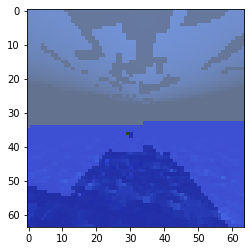

In [0]:
env.

EnvSpec(MineRLNavigateDense-v0)

In [0]:
env.observation_space

Dict(compassAngle:Box(1,), inventory:Dict(dirt:Box(1,)), pov:Box(64, 64, 3))